In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv(r"C:\Users\JATIN\OneDrive\Desktop\IPN31152N.csv",index_col='DATE',parse_dates=True)

In [3]:
df.head()

,IPN31152N
DATE,
1972-01-01,60.1529
1972-02-01,67.2738
1972-03-01,74.4713
1972-04-01,78.3607
1972-05-01,85.0335


In [5]:
df.columns=['Production']

In [6]:
df.head()

,Production
DATE,
1972-01-01,60.1529
1972-02-01,67.2738
1972-03-01,74.4713
1972-04-01,78.3607
1972-05-01,85.0335


<AxesSubplot:xlabel='DATE'>

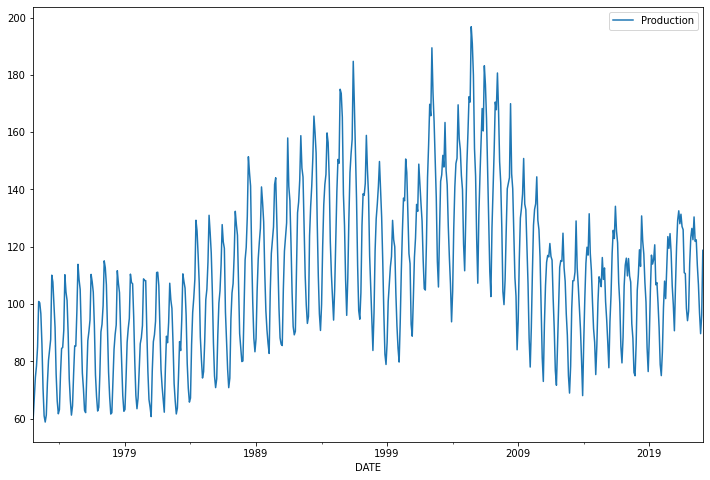

In [7]:
df.plot(figsize=(12,8))

In [8]:
len(df)

614

In [9]:
test_size=24
test_ind=len(df)-test_size

In [10]:
test_ind

590

In [11]:
train=df.iloc[:test_ind]
test=df.iloc[test_ind:]

In [12]:
len(train)

590

In [13]:
len(test)

24

In [14]:
train

,Production
DATE,
1972-01-01,60.1529
1972-02-01,67.2738
1972-03-01,74.4713
1972-04-01,78.3607
1972-05-01,85.0335
...,...
2020-10-01,106.4076
2020-11-01,99.7686
2020-12-01,90.7003


In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler=MinMaxScaler()

In [17]:
scaler.fit(train)

MinMaxScaler()

In [19]:
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

In [20]:
scaled_train

array([[0.00946844],
       [0.06107885],
       [0.11324444],
       [0.14143379],
       [0.18979649],
       [0.30491157],
       [0.30149644],
       [0.27411739],
       [0.19733776],
       [0.08531384],
       [0.0156138 ],
       [0.        ],
       [0.01773956],
       [0.09849312],
       [0.15587563],
       [0.18355909],
       [0.20875512],
       [0.37144363],
       [0.35419836],
       [0.29812914],
       [0.23970223],
       [0.12102706],
       [0.05289471],
       [0.02087566],
       [0.03141387],
       [0.12131987],
       [0.18620451],
       [0.18853176],
       [0.23180437],
       [0.37259312],
       [0.32887912],
       [0.30805709],
       [0.22407684],
       [0.10933284],
       [0.05452473],
       [0.01750039],
       [0.04077214],
       [0.12185258],
       [0.19275429],
       [0.19219042],
       [0.28135425],
       [0.39892125],
       [0.35979941],
       [0.33565213],
       [0.22869872],
       [0.1240182 ],
       [0.08401142],
       [0.029

In [22]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [24]:
length=18 #is less than the test size
n_features=1
generator=TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [26]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [30]:
validation_generator=TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
early_stop=EarlyStopping(monitor='val_loss', patience=2)

In [33]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


C:\Users\JATIN\AppData\Local\Temp\ipykernel_24344\1350552164.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


572/572 [==============================] - 6s 8ms/step - loss: 0.0270 - val_loss: 0.0064
Epoch 2/20
572/572 [==============================] - 4s 7ms/step - loss: 0.0073 - val_loss: 0.0032
Epoch 3/20
572/572 [==============================] - 4s 6ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 4/20
572/572 [==============================] - 4s 6ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 5/20
572/572 [==============================] - 4s 7ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 6/20
572/572 [==============================] - 4s 7ms/step - loss: 0.0030 - val_loss: 0.0033


In [36]:
losses=pd.DataFrame(model.history.history)

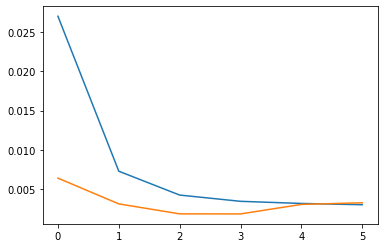

In [37]:
plt.plot(losses)

In [38]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    

1/1 [==============================] - 0s 33ms/step


In [39]:
true_predictions = scaler.inverse_transform(test_predictions)

In [40]:
test

,Production
DATE,
2021-03-01,129.3044
2021-04-01,132.5577
2021-05-01,128.0570
2021-06-01,131.3761
2021-07-01,127.0658
2021-08-01,125.9840
2021-09-01,110.9484
2021-10-01,110.6657
2021-11-01,98.5450


In [41]:
test['Predictions']=true_predictions

C:\Users\JATIN\AppData\Local\Temp\ipykernel_24344\2664784394.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions']=true_predictions


In [42]:
test

,Production,Predictions
DATE,,
2021-03-01,129.3044,118.338271
2021-04-01,132.5577,123.247115
2021-05-01,128.0570,126.446734
2021-06-01,131.3761,126.095804
2021-07-01,127.0658,121.734844
2021-08-01,125.9840,113.057892
2021-09-01,110.9484,102.660032
2021-10-01,110.6657,93.643676
2021-11-01,98.5450,88.016297


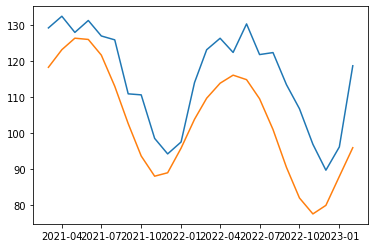

In [44]:
plt.plot(test)

In [45]:
from sklearn.metrics import mean_squared_error

In [46]:
np.sqrt(mean_squared_error(test['Production'],test['Predictions']))

13.654475051536462